In [1]:
import pandas as pd
import numpy as np
import string
import copy
import glob
import networkx as nx

In [2]:
_UNIQUE_DICTIONARY = string.ascii_letters+string.digits

# Schema Perturbation Function

def generate_prefix(symbol_dict: str=_UNIQUE_DICTIONARY, size: int=5) -> str:
    return ''.join(np.random.choice(list(symbol_dict), size))


def perturb_string(original_string, beta, prefix_change=False):
    if prefix_change:
        return generate_prefix()+'__'+original_string.split('__')[1]
    else:
        strlen = len(original_string)
        new_string=list(original_string)
        pertrub_idxs = np.random.randint(0,strlen, int(np.ceil(beta*strlen))).tolist()
        for ix in pertrub_idxs:
            new_string[ix] = np.random.choice(list(_UNIQUE_DICTIONARY),1)[0]
        return "".join(new_string)


def perturb_schema(input_df, alpha=0.5, prefix_change=False, beta=0.2):
    original_column_set = set(input_df.columns)
    rename_map = {}
    cols_to_rename = np.random.choice(list(original_column_set), int(np.ceil(alpha*len(original_column_set))))
    
    for col_to_rename in cols_to_rename:
        rename_map[col_to_rename] = perturb_string(col_to_rename, beta=beta, prefix_change=prefix_change)
    
    return input_df.rename(columns=rename_map)

In [62]:
test_df = pd.read_csv('/tmp/fuzzydatatest/modin_ray/artifacts/artifact_0.csv', index_col=0).drop('Unnamed: 0', axis=1)
test_df
renamed_df = perturb_schema(test_df)

set(test_df.columns).symmetric_difference(set(renamed_df.columns))

{'07i5S5_phone_numbZa',
 '07i5S__phone_number',
 'PdFsM__pyfloat',
 'Pdws8__pyfOoat',
 'TvxTJ__sha1',
 'TvxhJ__sCa1',
 'bp0Rn_3wird',
 'bpLRn__word',
 'q9p2y__mac_processor',
 'q9p2y_rmac_ptocUssor',
 'svtGf__pySloaU',
 'svtGf__pyfloat',
 'vxXvMTyascii_sgme_emahl',
 'vxXvM__ascii_safe_email'}

In [52]:
perturb_string('t19zm__ean8', 0.5, prefix_change=False)

't19jm_pUPnM'

In [77]:
from collections import defaultdict
# Schema Perturbation for the entire dataset based on a common schema map


_UNIQUE_DICTIONARY = string.ascii_letters+string.digits

# Schema Perturbation Function

def generate_prefix(symbol_dict: str=_UNIQUE_DICTIONARY, size: int=5) -> str:
    return ''.join(np.random.choice(list(symbol_dict), size))


def perturb_string(original_string, beta, prefix_change=False):
    if prefix_change:
        return generate_prefix()+'__'+original_string.split('__')[1]
    else:
        strlen = len(original_string)
        new_string=list(original_string)
        pertrub_idxs = np.random.randint(0,strlen, int(np.ceil(beta*strlen))).tolist()
        for ix in pertrub_idxs:
            new_string[ix] = np.random.choice(list(_UNIQUE_DICTIONARY),1)[0]
        return "".join(new_string)
    
    
def find_nodes_with_op_ancestor(gt_graph, op_list = ['pivot']):
    # Generate reverse graph
    rev_graph = nx.reverse(gt_graph)
    all_ancestors = [x for x in rev_graph.nodes() if rev_graph.out_degree(x)==0]
    dont_perturb = set()

    for u in rev_graph.nodes():
        if u not in all_ancestors:
            for v in rev_graph.nodes():
                try:
                    walk_path = nx.shortest_path(rev_graph, u, v)
                    pathGraph = nx.path_graph(walk_path)  
                    path_ops = [gt_graph[v][u]['operation'] for u,v in pathGraph.edges()]
                    if set(op_list).intersection(set(path_ops)):
                        dont_perturb.add(u)
                except nx.exception.NetworkXNoPath as e:
                    pass
    return dont_perturb


def perturb_schema_dataset(df_dict, gt_graph, alpha=0.5, prefix_change=False, beta=0.2, gamma=0.4):
    
    # Select artifacts that do not have a pivot ancestry
    have_pivot_ancestry = find_nodes_with_op_ancestor(gt_graph)
    ok_to_perturb = set(df_dict.keys()).difference(have_pivot_ancestry) 
    
    
    # Generate inverse schema map from df dict for dfs that are ok:
    inv_col_map = defaultdict(list)
    for df_label, df in df_dict.items():
        if df_label in ok_to_perturb:
            for col in df.columns:
                inv_col_map[col].append(df_label)
    
    
    # Filter by columns that have atleast two dfs attached
    inv_col_map = {k:v for k,v in inv_col_map.items() if len(v)>=2}   
    
    # Select alpha ratio of columns to perturb - only columns that are present in more than one artifact.
    num_to_perturb = max(1,int(np.ceil(len(inv_col_map) * alpha)))
    columns_to_perturb = np.random.choice(list(inv_col_map.keys()), num_to_perturb, replace=False).tolist()
    
    renamed_df_dict = copy.deepcopy(df_dict)
    rename_map = defaultdict(dict)
    
    # Generate randint [1,gamma] versions of each column to be changed
    for col in columns_to_perturb:
        dfs_with_col = inv_col_map[col]
        num_to_perturb = np.random.randint(1, max(1,int(np.ceil(len(dfs_with_col) * gamma))))
        dfs_to_perturb = np.random.choice(dfs_with_col, num_to_perturb).tolist()
        
        new_col_label = perturb_string(col, beta=beta, prefix_change=prefix_change)
        
        print(f'Modifying: {col}--->{new_col_label} in {dfs_to_perturb}')
        
        for df_label in dfs_to_perturb:
            renamed_df_dict[df_label] = renamed_df_dict[df_label].rename(columns={col: new_col_label})
            rename_map[df_label].update({col: new_col_label})
            
            
    return renamed_df_dict, rename_map
    
    # Perturb them by beta
    
#     original_column_set = set(input_df.columns)
#     rename_map = {}
#     cols_to_rename = np.random.choice(list(original_column_set), int(np.ceil(alpha*len(original_column_set))))
    
#     for col_to_rename in cols_to_rename:
#         rename_map[col_to_rename] = perturb_string(col_to_rename, beta=beta, prefix_change=prefix_change)
    
#     return input_df.rename(columns=rename_map)


In [ ]:
'/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact/20210126-153741/20210126-153741_gt_edgelist.txt'

In [80]:
from relic.utils.serialize import build_df_dict

base_dir = '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact/'
nb_name = '20210126-153741'


df_dict = build_df_dict(nb_name, base_dir)
gpkl_file = glob.glob(f"{base_dir}/{nb_name}/*_gt_fixed.pkl")[0]
gt_graph = nx.read_gpickle(gpkl_file)

r_df_dict, rename_map = perturb_schema_dataset(df_dict, gt_graph, alpha=0.5, prefix_change=False, beta=0.2)
rename_map

Loading DFs:   0%|          | 0/20 [00:00<?, ?it/s]

Modifying: phone_number--->6hoRe_nuVber in ['8.csv']
Modifying: credit_card_provider--->creditZcard_pToSidew in ['1.csv', '18.csv']
Modifying: bs--->b4 in ['4.csv']
Modifying: sha1--->shD1 in ['18.csv', '17.csv']
Modifying: bban--->bLan in ['2.csv']
Modifying: safe_email--->Yafe_eLail in ['2.csv']
Modifying: zipcode_in_state--->zipcodeYinplqate in ['7.csv']
Modifying: last_name--->lasY_naHe in ['16.csv']
Modifying: pyint__70x+51--->pSint__x0I+51 in ['12.csv']
Modifying: opera--->lpera in ['2.csv']
Modifying: word--->wors in ['4.csv']
Modifying: month_name--->mo3tn_name in ['15.csv']
Modifying: postcode--->pTs8code in ['7.csv', '1.csv']
Modifying: email--->emaiP in ['17.csv', '8.csv']
Modifying: currency_code--->curr3ncy_code in ['16.csv']
Modifying: pystr--->Dystr in ['19.csv']
Modifying: rgb_color--->rgb3coRor in ['7.csv']
Modifying: suffix_male--->EuQfix_maqe in ['4.csv']


defaultdict(dict,
            {'8.csv': {'phone_number': '6hoRe_nuVber', 'email': 'emaiP'},
             '1.csv': {'credit_card_provider': 'creditZcard_pToSidew',
              'postcode': 'pTs8code'},
             '18.csv': {'credit_card_provider': 'creditZcard_pToSidew',
              'sha1': 'shD1'},
             '4.csv': {'bs': 'b4',
              'word': 'wors',
              'suffix_male': 'EuQfix_maqe'},
             '17.csv': {'sha1': 'shD1', 'email': 'emaiP'},
             '2.csv': {'bban': 'bLan',
              'safe_email': 'Yafe_eLail',
              'opera': 'lpera'},
             '7.csv': {'zipcode_in_state': 'zipcodeYinplqate',
              'postcode': 'pTs8code',
              'rgb_color': 'rgb3coRor'},
             '16.csv': {'last_name': 'lasY_naHe',
              'currency_code': 'curr3ncy_code'},
             '12.csv': {'pyint__70x+51': 'pSint__x0I+51'},
             '15.csv': {'month_name': 'mo3tn_name'},
             '19.csv': {'pystr': 'Dystr'}})

In [112]:
# Testing the relic-integrated flow with valentine here

from valentine import valentine_match, valentine_metrics
from valentine.algorithms import SimilarityFlooding
from valentine.metrics.metrics import one_to_one_matches

def schema_match_df_combo(tup, r_df_dict, already_matched=False):
    unmatched_cols = set(r_df_dict[tup[0]]).symmetric_difference(set(r_df_dict[tup[1]]))

    if unmatched_cols:
        matcher = SimilarityFlooding()
        matches = one_to_one_matches(valentine_match(r_df_dict[tup[0]], r_df_dict[tup[1]], matcher, tup[0], tup[1]))
        
        for ((src_df_label, src_col_label), (dest_df_label, dest_col_label)) in matches.keys():
            if src_col_label != dest_col_label:
                r_df_dict[dest_df_label] = r_df_dict[dest_df_label].rename({dest_col_label: src_col_label})
    
    return r_df_dict, matches

def schema_match_df_triple(tup, r_df_dict, already_matched=False):
    join_dest = None
    max_col_size = 0
    for t in tup:
        if len(set(r_df_dict[t])) > max_col_size:
            join_dest = t
            max_col_size = len(set(r_df_dict[t]))
            
    join_sources = tuple(t for t in tup if t != join_dest)
    
    unmatched_cols = set(r_df_dict[join_sources[0]]).symmetric_difference(set(r_df_dict[join_dest]))
    unmatched_cols.union(set(r_df_dict[join_sources[1]]).symmetric_difference(set(r_df_dict[join_dest])))

    if unmatched_cols:
        matcher = SimilarityFlooding()
        matches_1 = one_to_one_matches(valentine_match(r_df_dict[join_sources[0]], 
                                                     r_df_dict[join_dest], matcher, 
                                                     join_sources[0], join_dest))
        
        for ((src_df_label, src_col_label), (dest_df_label, dest_col_label)) in matches_1.keys():
            if src_col_label != dest_col_label:
                r_df_dict[src_df_label] = r_df_dict[src_df_label].rename({src_col_label: dest_col_label})
                
        matcher = SimilarityFlooding()
        matches_2 = one_to_one_matches(valentine_match(r_df_dict[join_sources[1]], 
                                                     r_df_dict[join_dest], matcher, 
                                                     join_sources[1], join_dest))
        
        for ((src_df_label, src_col_label), (dest_df_label, dest_col_label)) in matches_2.keys():
            if src_col_label != dest_col_label:
                r_df_dict[src_df_label] = r_df_dict[src_df_label].rename({src_col_label: dest_col_label})
                
        matches_1.update(matches_2)
    
    return r_df_dict, matches_1


tup = ('1.csv', '6.csv', '7.csv')
n_df_dict, m_1 = schema_match_df_triple(tup, r_df_dict)
m_1

{(('1.csv', 'date'), ('7.csv', 'date')): 0.1850290489375936,
 (('1.csv', 'pTs8code'), ('7.csv', 'pTs8code')): 0.18078509464624615,
 (('1.csv', 'opera'), ('7.csv', 'opera')): 0.1786254316944391,
 (('1.csv', 'uri_extension'), ('7.csv', 'uri_extension')): 0.1786254316944391,
 (('1.csv', 'phone_number'), ('7.csv', 'phone_number')): 0.1786254316944391,
 (('1.csv', 'bban'), ('7.csv', 'bban')): 0.1786254316944391,
 (('1.csv', 'street_suffix'), ('7.csv', 'street_suffix')): 0.1786254316944391,
 (('1.csv', 'pystr'), ('7.csv', 'pystr')): 0.1786254316944391,
 (('1.csv', 'creditZcard_pToSidew'),
  ('7.csv', 'credit_card_provider')): 0.1568594477517564,
 (('6.csv', 'msisdn'), ('7.csv', 'msisdn')): 0.18127960479210783,
 (('6.csv', 'city'), ('7.csv', 'city')): 0.17980474709021954,
 (('6.csv', 'sha1'), ('7.csv', 'sha1')): 0.17980474709021954,
 (('6.csv', 'ipv4_public'), ('7.csv', 'ipv4_public')): 0.17980474709021954,
 (('6.csv', 'email'), ('7.csv', 'email')): 0.17980474709021954,
 (('6.csv', 'bban'), (

In [82]:
r_df_dict

{'11.csv':           East    Lake     New   North    Port   South    West
 suffix                                                        
 DDS     6684.0  7768.0  9520.0  8552.0  7058.0  9850.0  9671.0
 DVM     4961.0  8244.0  3235.0  1267.0  8067.0  7618.0  5245.0
 II      5911.0     NaN     NaN     NaN     NaN     NaN  9751.0
 III        NaN     NaN     NaN  6534.0     NaN     NaN  2294.0
 IV         NaN     NaN     NaN     NaN     NaN     NaN  2315.0
 Jr.     3152.0  2645.0  9722.0  4056.0  5480.0  4044.0  4929.0
 MD      9937.0  9227.0  5725.0  5443.0  6963.0  4063.0  8061.0
 PhD     2106.0  8749.0     NaN     NaN  9176.0     NaN  8659.0,
 '16.csv':     building_number   unix_time     color_name free_email_domain  \
 0              8547   826102059  PaleGoldenRod         gmail.com   
 1              3775   176367700     DodgerBlue         gmail.com   
 2              9405  1394981844       Moccasin         yahoo.com   
 3             21181  1057995015   MediumPurple         gmail.c

# DEBUG

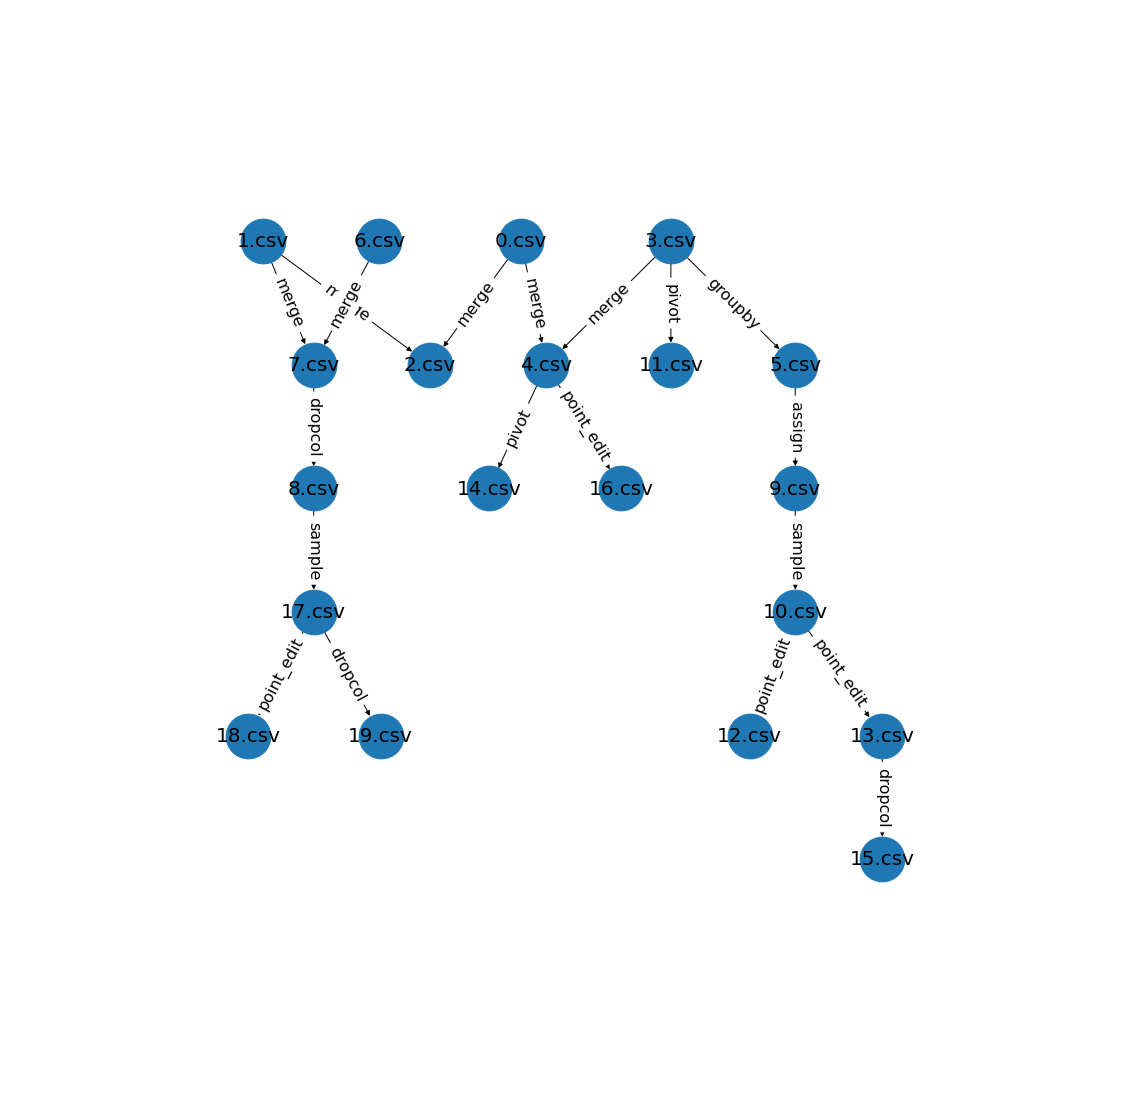

<module 'matplotlib.pyplot' from '/home/suhail/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [105]:
draw_graph(gt_graph, canvas_size=(20,20))

In [15]:
from relic.graphs.graphs import draw_graph
base_dir = '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact/20210126-153741/'
gpkl_file = glob.glob(f"{base_dir}/*_gt_fixed.pkl")[0]
gt_graph = nx.read_gpickle(gpkl_file)



,source,target,operation,args
0,0.csv,2.csv,merge,{'key': 'pystr'}
1,0.csv,4.csv,merge,{'key': 'building_number'}
2,1.csv,2.csv,merge,{'key': 'pystr'}
3,1.csv,7.csv,merge,{'key': 'bban'}
4,3.csv,4.csv,merge,{'key': 'building_number'}
5,3.csv,5.csv,groupby,"{'col': ['month_name'], 'func': 'mean'}"
6,3.csv,11.csv,pivot,"{'index': 'suffix', 'column': 'city_prefix', '..."
7,4.csv,14.csv,pivot,"{'index': 'free_email_domain', 'column': 'suff..."
8,4.csv,16.csv,point_edit,"{'col': 'unix_time', 'old_value': 1302833016, ..."
9,5.csv,9.csv,assign,"{'string_or_numeric': 'numeric', 'col': 'pyint..."


In [37]:
find_nodes_with_op_ancestor(gt_graph, op_list=['pivot'])

{'11.csv', '14.csv'}

In [34]:
any(['pivot']) in ['groupby', 'pivot']

False

In [11]:
import os
# Find all pivots in the big workflows

base_dir = '/mnt/roscoe/data/relic/relic_datasets_vldb_2021/dataset_flat_exact/'
def process_directory(base_dir):
    workflow_ids = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    all_results = []
    edges_df = pd.DataFrame()
    for i in workflow_ids:
        try:
            gt_file = glob.glob(f"{base_dir}/{i}/*_gt_fixed.pkl")[0]
            gt_graph = nx.read_gpickle(gt_file)
            result_dict = nx.to_pandas_edgelist(gt_graph)
            result_dict['wf_id'] = i
            all_results.append(result_dict)
        except Exception as e:
            print(i)
    
    return pd.concat(all_results)

all_edges = process_directory(base_dir)
all_edges

20210126-181148


,source,target,operation,args,wf_id
0,0.csv,1.csv,dropcol,{'col': 'suffix'},20210126-153758
1,1.csv,3.csv,merge,{'key': 'sha1'},20210126-153758
2,1.csv,9.csv,point_edit,"{'col': 'bs', 'old_value': 'e-enable integrate...",20210126-153758
3,2.csv,3.csv,merge,{'key': 'sha1'},20210126-153758
4,2.csv,4.csv,groupby,"{'col': ['street_suffix'], 'func': 'count'}",20210126-153758
...,...,...,...,...,...
44,41.csv,47.csv,merge,{'key': 'ipv4_public'},20210126-191713
45,42.csv,44.csv,point_edit,"{'col': 'military_ship', 'old_value': 'USS', '...",20210126-191713
46,44.csv,49.csv,assign,"{'string_or_numeric': 'numeric', 'col': 'rando...",20210126-191713
47,46.csv,47.csv,merge,{'key': 'ipv4_public'},20210126-191713


In [12]:
all_edges['operation'].value_counts()

dropcol       1401
sample        1401
point_edit    1301
merge         1074
assign         638
groupby        611
pivot          325
Name: operation, dtype: int64

In [14]:
set(all_edges.loc[all_edges.operation == 'pivot'].wf_id.values)

{'20210126-153741',
 '20210126-153820',
 '20210126-153825',
 '20210126-153832',
 '20210126-153836',
 '20210126-153845',
 '20210126-153900',
 '20210126-153957',
 '20210126-154258',
 '20210126-154842',
 '20210126-155148',
 '20210126-155348',
 '20210126-155724',
 '20210126-155747',
 '20210126-155943',
 '20210126-160531',
 '20210126-160651',
 '20210126-160727',
 '20210126-160736',
 '20210126-160740',
 '20210126-160812',
 '20210126-160816',
 '20210126-160823',
 '20210126-160851',
 '20210126-160904',
 '20210126-160913',
 '20210126-160925',
 '20210126-161013',
 '20210126-161024',
 '20210126-161736',
 '20210126-161841',
 '20210126-161913',
 '20210126-162922',
 '20210126-163005',
 '20210126-163615',
 '20210126-163640',
 '20210126-163943',
 '20210126-164315',
 '20210126-164457',
 '20210126-165010',
 '20210126-165949',
 '20210126-170140',
 '20210126-170349',
 '20210126-170821',
 '20210126-170911',
 '20210126-170936',
 '20210126-171040',
 '20210126-171058',
 '20210126-171124',
 '20210126-171144',


In [125]:
import itertools
alphas=map(str,[0.1,0.5,0.75])
betas=map(str, [0.1,0.5,0.75])
gammas=map(str, [0.3,0.4,0.5])
rand_wfs = np.random.choice(list(set(all_edges.wf_id.values)),5)
base_dir = '/tank/local/suhail/data/relic/perturbed/dataset_flat_exact/'
[print(f"{base_dir}{'/'.join(x)}") for x in itertools.product(alphas,betas,gammas,rand_wfs)]

/tank/local/suhail/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-181822
/tank/local/suhail/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-155620
/tank/local/suhail/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-183630
/tank/local/suhail/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-171602
/tank/local/suhail/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.3/20210126-181345
/tank/local/suhail/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-181822
/tank/local/suhail/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-155620
/tank/local/suhail/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-183630
/tank/local/suhail/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-171602
/tank/local/suhail/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.4/20210126-181345
/tank/local/suhail/data/relic/perturbed/dataset_flat_exact/0.1/0.1/0.5/20210126-181822
/tank/local/suhail/data/relic/perturbed/dat

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]